# Lesson 6: Decisions

## Intro to Quantified Cognition

By: Per B. Sederberg, PhD


<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2022_Fall/notebooks/06_Decisions.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>



## Lesson plan

- Intro to cognitive models
- Pivot to decision-making models
- Exploration of decision-making data
- Linear Ballistic Accumulator exploration
- Model fits to data


## The Mind as a Black Box

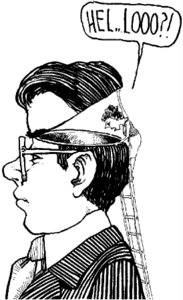

- Stuff comes in, behaviors come out...
- But what's going on in the box?

![](http://25.media.tumblr.com/tumblr_ljpq2nYt9D1qzgjfco1_500.gif)

## It's all RAD

### ***Representations***
### ***Associations***
### ***Dynamics***

## Decisions as an important and accessible cognitive process

- Although we could try and open the box for all sorts of cognitive behaviors (e.g., perception, memory, etc...), decision making is a pervasive aspect of our lives.

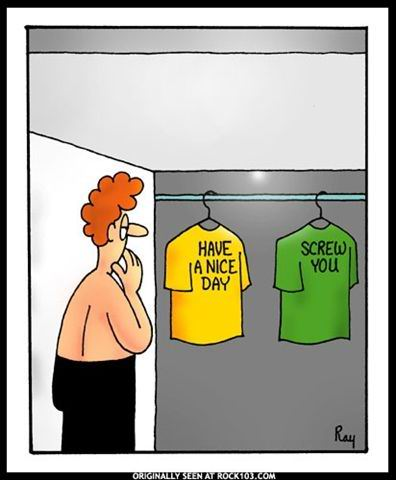

- What are some examples of decisions we make?


## How do we study decisions?

- What food would you rather eat?
- What direction are these dots moving?

## Questions we ask about decisions

- What choice did you make?
- How quickly did you make it?

## Example: Speed--Accuracy trade-off

- Sometimes we have to make fast decisions
- Other times we just need to be as accurate as possible.

## If on Google Colab

In [1]:
# to install RunDEMC (note the upgrade argument!!!)
!pip install fastprogress
!pip install KDEpy
!pip install arviz
!pip install --upgrade git+https://github.com/compmem/RunDEMC.git


  Cloning https://github.com/compmem/RunDEMC.git to /tmp/pip-req-build-vy6znyej
  Running command git clone -q https://github.com/compmem/RunDEMC.git /tmp/pip-req-build-vy6znyej
  Created wheel for RunDEMC: filename=RunDEMC-0.1.0-py3-none-any.whl size=47262 sha256=db6ec4af20529454a116d1d5905c8bdef0da66733d5fd5924d7a963ecbcad5b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-6eqdrs6x/wheels/79/3a/34/0f720f2600b6465d20f6d89bdfe546c94d87a0074d5e687312
Successfully built RunDEMC
  Attempting uninstall: RunDEMC
    Found existing installation: RunDEMC 0.1.0
    Uninstalling RunDEMC-0.1.0:
      Successfully uninstalled RunDEMC-0.1.0


In [2]:
# to retrieve the data
!wget https://raw.githubusercontent.com/compmem/QuantCog/2022_Fall/notebooks/decision_data.csv

--2021-03-18 12:22:02--  https://raw.githubusercontent.com/compmem/QuantCog/2021_Spring/notebooks/decision_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-03-18 12:22:02 ERROR 404: Not Found.



## Load modules

In [1]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats
import arviz as az

from ipywidgets import interact, fixed

from KDEpy import FFTKDE

## Load and process the data

In [2]:
# load in the data
dat = pd.read_csv('decision_data.csv', index_col=0)

# get rid of the neutral condition
dat = dat[dat.cond != 'Neutral']

# make a new column that combines accuracy and rt
dat['rt_acc'] = dat['rt']
dat.loc[dat.correct==0,'rt_acc'] = -dat['rt']
dat.head()

,correct,rt,cond,log_rt,rt_acc
3,1,0.4784,Accuracy,-0.737308,0.4784
4,1,0.4300,Accuracy,-0.843970,0.4300
5,1,0.4486,Accuracy,-0.801624,0.4486
6,1,0.3991,Speed,-0.918543,0.3991
8,1,0.4393,Accuracy,-0.822573,0.4393


## Basic behavioral summary

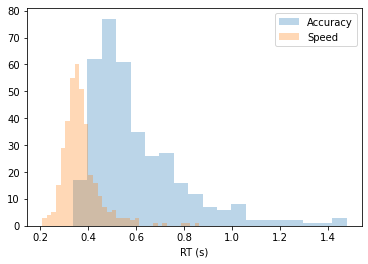

In [8]:
# plot histograms of RTs
plt.hist(dat.loc[dat.cond=='Accuracy', 'rt'], bins='auto', alpha=.3);
plt.hist(dat.loc[dat.cond=='Speed', 'rt'], bins='auto', alpha=.3);
plt.legend(['Accuracy', 'Speed'])
plt.xlabel('RT (s)');

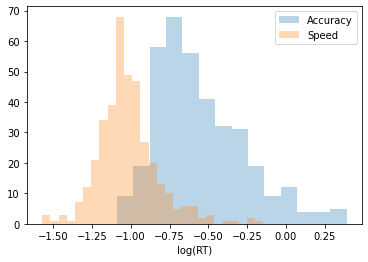

In [9]:
# Try log RTs
# plot histograms of RTs
plt.hist(dat.loc[dat.cond=='Accuracy', 'log_rt'], bins='auto', alpha=.3);
plt.hist(dat.loc[dat.cond=='Speed', 'log_rt'], bins='auto', alpha=.3);
plt.legend(['Accuracy', 'Speed'])
plt.xlabel('log(RT)');

In [39]:
# show trade-off between speed and accuracy
df = dat.groupby(['cond'])[['rt','correct']].mean().reset_index()
df

,cond,rt,correct
0,Accuracy,0.602144,0.880109
1,Speed,0.369051,0.657068


In [9]:
# RT split out by condition and accuracy
dat.groupby(['cond', 'correct'])['rt'].mean().reset_index()


,cond,correct,rt
0,Accuracy,0,0.589848
1,Accuracy,1,0.603819
2,Speed,0,0.349665
3,Speed,1,0.379169


## What does this tell us?

- Looking at behavioral effects alone can not reveal the processes that gave rise to that choice and RT.

- i.e., if you made a specific response, we don't know *why* you made that response.

## Going Deeper: What affects your decisions? 


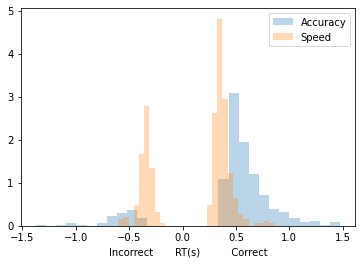

In [48]:
plt.hist(dat.loc[dat.cond=='Accuracy', 'rt_acc'], density=True, alpha=0.3, bins=30);
plt.hist(dat.loc[dat.cond=='Speed', 'rt_acc'], density=True, alpha=0.3, bins=30);
plt.xlabel('Incorrect       RT(s)          Correct')
plt.legend(['Accuracy', 'Speed'])

## What is a computational model? 

- Take processes and instantiate them within a set of equations with explicit rules for how they interact.

## Linear Ballistic Accumlator (LBA)

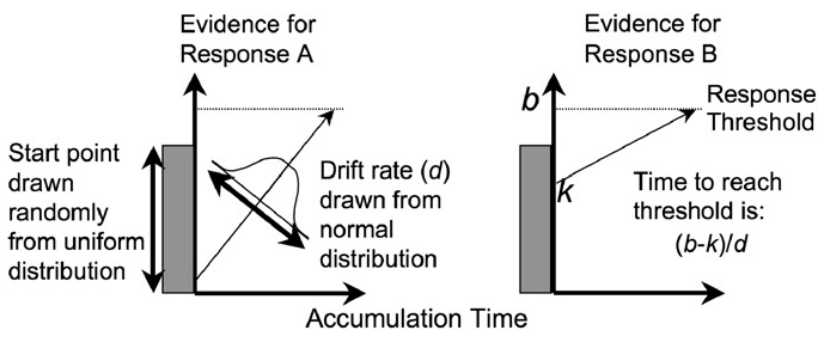

In [27]:
def lba_sim(I=(1.0,1.5), A=.1, S=1.0, b=1.0, num_sims=1000,
            max_time=2., t0=0.0, **kwargs):
    # set drift rate from inputs
    dr = np.squeeze(np.atleast_1d(I))
    
    # set the number of choices
    nc = len(dr)
    
    # pick starting points
    k = np.random.uniform(0.,A,(num_sims,nc))
    
    # pick drifts
    # must make sure at least one d is greater than zero for each sim
    d = np.random.normal(dr,S,(num_sims,nc))
    # see where there are none above zero
    ind = np.all(d<=0.0,axis=1)
    while np.any(ind):
        d[ind,:] = np.random.normal(dr,S,(ind.sum(),nc))
        ind = np.all(d<=0.0,axis=1)

    # clip it to avoid divide by zeros
    d[d<=0.0] = np.finfo(dr.dtype).eps

    # calc the times for each
    t = (b-k)/d

    # see the earliest for each resp
    inds = t.argmin(1)
    times = t.take(inds+np.arange(t.shape[0])*t.shape[1])

    # process into choices
    times += t0

    # get valid responses
    resp_ind = times < (max_time)
    inds[~resp_ind] = -1
    times[~resp_ind] = -1
    
    # make a dataframe
    return pd.DataFrame({'correct': inds, 'rt': times})


In [28]:
# set up the sim
nsims = 5000
cond='Accuracy'
ndat = (dat['cond']==cond).sum()
plt.figure(figsize=(10,6))

# normed histogram
def dhist(dat, nsims, alpha=.3, color='b'):
    p,b = np.histogram(dat,bins='auto',density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nsims
    return plt.bar(b[1:]-w,p,width=w,alpha=.3,color=color)

# normed pdf
xvals = np.linspace(0.1,2.0,100)
def dplot(dat, nsims, color='b', lw=2.):
    xp, fp = FFTKDE(kernel='gaussian', bw='silverman').fit(dat).evaluate()
    p = np.interp(xvals, xp, fp)
    p *= float(len(dat))/nsims
    plt.plot(xvals, p, color=color, lw=2.)

# put it all together
@interact(d1=(0.0,5.0,0.05),
          d2=(0.0,5.0,0.05),
          A=(0.0,1.0,.05),
          b=(0.0,5.0,.05),
          t0=(0.0,1.0,.02),
          S=fixed(1.0)
          )
def run_lba(d1=1.0, d2=2.0, A=.1, b=1.0, t0=0.0, S=1.0):
    # run the LBA model
    res = lba_sim(I=(d1, d2), A=A, S=S, b=b, num_sims=nsims, max_time=2.0, t0=t0)
    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
    dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
    dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
    #ylim(0,5.0)
    plt.xlim(0,2.0)

<Figure size 720x432 with 0 Axes>

interactive(children=(FloatSlider(value=1.0, description='d1', max=5.0, step=0.05), FloatSlider(value=2.0, des…

## Using computers to test hypotheses

In [25]:
from RunDEMC import Model, Param, dists
from RunDEMC.pda import PDA
from RunDEMC.io import arviz_dict

## Fitting Decision Models

What do we do when our model doesn't have an analytical likelihood function?

PDA to the rescue!!!

## Probability Density Approximation

Applies a kernel density estimate (KDE) to simulated data.

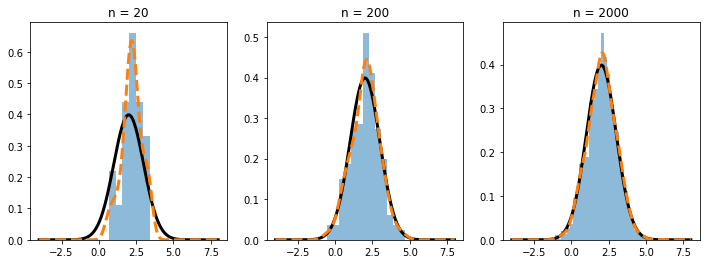

In [19]:
# generate some data from a known distribution
true_mean = 2.0
true_std = 1.0
dist = dists.normal(mean=true_mean, std=true_std)
rdat = dist.rvs(2000)

# define range for plots
xrng = np.linspace(-4,8.0,200)

# plot different amounts of data with a kernel density estimate
plt.figure(figsize=(12, 4))
for i, n in enumerate([20, 200, 2000]):
    # pick the subplot
    plt.subplot(1, 3, i+1)
    
    # plot the actual data
    plt.hist(rdat[:n], bins='auto', density=True, alpha=0.5);
    
    # plot the true PDF
    plt.plot(xrng, dist.pdf(xrng), 'k', lw=3)
    
    # plot the kde
    p = FFTKDE(kernel='gaussian', bw='silverman').fit(rdat[:n]).evaluate(xrng)
    plt.plot(xrng, p, '--', lw=3)
    
    # give title
    plt.title('n = %d' % n)


### Threshold-change model

In [52]:
# Test change in threshold

# set up the params
min_rt = dat.rt.min()
params = [Param(name='d1', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='A', prior=dists.trunc_normal(.5, 2.0, 0., 2.0)),
          Param(name='b_A', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='b_S', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.normal(0.0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]

# set up PDA
pda = PDA(dat.to_records(), cat_var='correct', 
          cont_var='rt', cond_var='cond')

# define the likelihood function
nsims = 10000
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first check for simple issues
        if (p['A'] > p['b_A']) or (p['A'] > p['b_S']) or \
            np.any(np.array(p.tolist())<0):
            # A can't be bigger than b
            likes[i] = -np.inf
            continue
            
        # first Accuracy
        # run the simulation
        resA = lba_sim(I=(p['d1'], p['d2']), A=p['A'], S=1.0, b=p['b_A'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])
        
        # add the cond
        resA['cond'] = 'Accuracy'
        
        # then Speed
        resS = lba_sim(I=(p['d1'], p['d2']), A=p['A'], S=1.0, b=p['b_S'], 
                       num_sims=nsims, max_time=2.0, t0=p['t0'])   
        
        # add the cond
        resS['cond'] = 'Speed'  
        
        # combine into one dataframe
        res = pd.concat([resA, resS], ignore_index=True)
        
        # convert fast responses to non-responses
        res.loc[res.rt < rt_min, 'correct'] = -1
        
        # calc log like via PDA
        likes[i] += pda.calc_log_like(res.to_records())
        if likes[i] == -np.inf:
            continue
        
    return likes
        
# make the model
m = Model('decisions_thresh', params=params,
          like_fun=like_fun,
          #like_args=(dat,),
          purify_every=5,
          pop_parallel=True,
          verbose=True)

In [53]:
# do some burnin
times = m.sample(100, burnin=True)
times = m.sample(600, burnin=False)

Initializing: 120(120) 42(42) 16(16) 2(2) 1(1) 1(1) 
Iterations (100):


Iterations (600):


KeyboardInterrupt: 

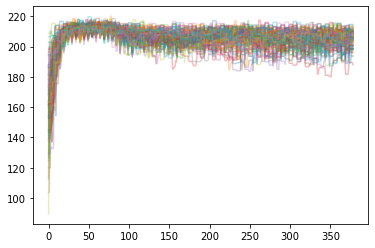

In [54]:
plt.plot(m.weights[25:], alpha=.3);

In [55]:
print("Best fitting params:")
burnin=5
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights.ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: 210.64201872656344
"d1": 1.328894,
"d2": 2.368275,
"A": 0.395019,
"b_A": 1.123372,
"b_S": 0.634564,
"t0": 0.185997,


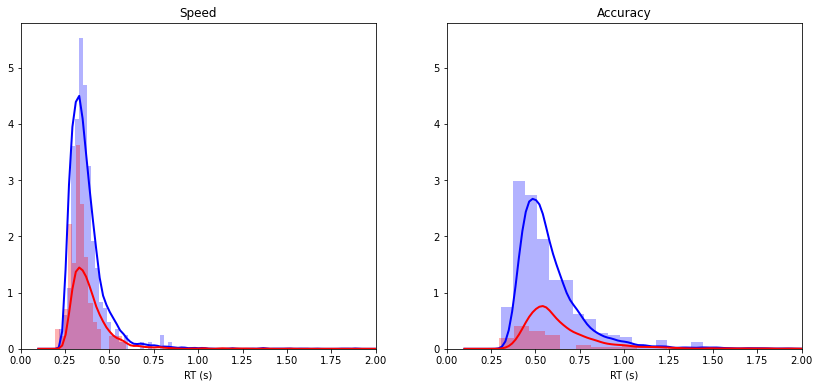

In [56]:
# Run sim with best fitting params
plt.figure(figsize=(14,6))
fig = plt.gcf()
ax1 = fig.add_subplot(121)

cond = 'Speed'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b_'+cond[0]], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax = plt.subplot(1,2,1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

cond = 'Accuracy'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b_'+cond[0]], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax2 = fig.add_subplot(122, sharey=ax1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);

In [61]:
daz = az.from_dict(**arviz_dict(m, burnin=200, step=7))

/home/per/anaconda3/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (120) than draws (30). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/per/anaconda3/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (1) than draws (0). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/per/anaconda3/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (120) than draws (30). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [62]:
az.summary(daz)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d1,1.483,0.206,1.127,1.909,0.011,0.008,370.0,340.0,1.30
d2,2.545,0.204,2.147,2.895,0.010,0.008,407.0,450.0,1.26
A,0.446,0.102,0.260,0.626,0.005,0.004,389.0,382.0,1.27
b_A,1.229,0.131,0.997,1.464,0.007,0.005,377.0,376.0,1.29
b_S,0.709,0.096,0.542,0.876,0.005,0.004,399.0,411.0,1.27
t0,0.183,0.021,0.146,0.208,0.001,0.001,270.0,290.0,1.50


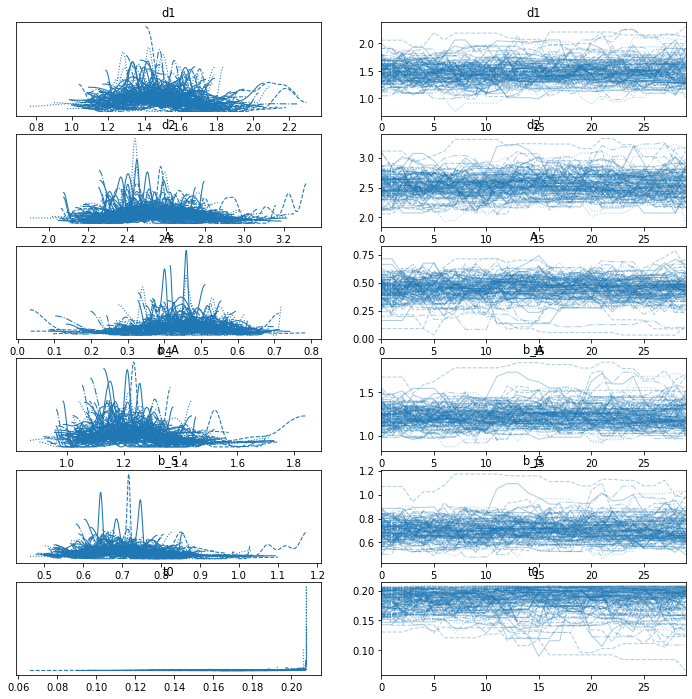

In [63]:
# check our trace
az.plot_trace(daz);

array([[<AxesSubplot:title={'center':'d1'}>,
        <AxesSubplot:title={'center':'d2'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'b_A'}>,
        <AxesSubplot:title={'center':'b_S'}>,
        <AxesSubplot:title={'center':'t0'}>]], dtype=object)

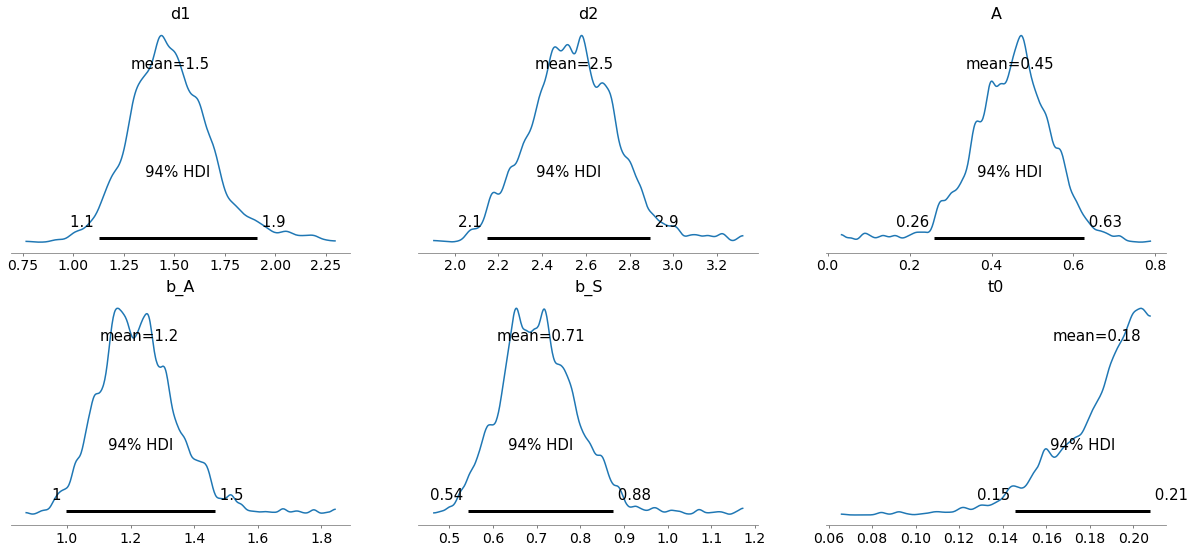

In [64]:
az.plot_posterior(daz)

## See you next class!!!

- Assignment 3 is due by Sunday night
- New assignment 4 will be posted tomorrow
- Next class we'll explore other decision models
